0 	MAE: 189505.0
PERFORMANCE ON TEST SET: loss = 48.497015644073485
100 	MAE: 22051.1
PERFORMANCE ON TEST SET: loss = 3.9775492782592776
200 	MAE: 17711.1
PERFORMANCE ON TEST SET: loss = 3.3201441116333
300 	MAE: 15199.6
PERFORMANCE ON TEST SET: loss = 2.6185602798461907
400 	MAE: 12518.1
PERFORMANCE ON TEST SET: loss = 1.9991126632690417
500 	MAE: 11980.2
PERFORMANCE ON TEST SET: loss = 1.8235642242431631
600 	MAE: 11932.8
PERFORMANCE ON TEST SET: loss = 1.8071753005981435
700 	MAE: 11818.3
PERFORMANCE ON TEST SET: loss = 1.827305541992186
800 	MAE: 11806.7
PERFORMANCE ON TEST SET: loss = 1.96368276977539
900 	MAE: 11697.6
PERFORMANCE ON TEST SET: loss = 1.96954214477539
[[[ 70.57920837]
  [ 67.34339142]
  [ 67.1084671 ]
  [ 67.13233948]
  [ 69.35800171]
  [ 67.46687317]
  [ 66.14445496]
  [ 65.93372345]
  [ 69.38815308]
  [ 68.91332245]
  [ 58.44413757]
  [ 61.2554245 ]
  [ 49.66736984]
  [ 48.77360916]
  [ 49.28965759]
  [ 51.65065765]
  [ 52.27412033]
  [ 61.61190796]
  [ 66.047966

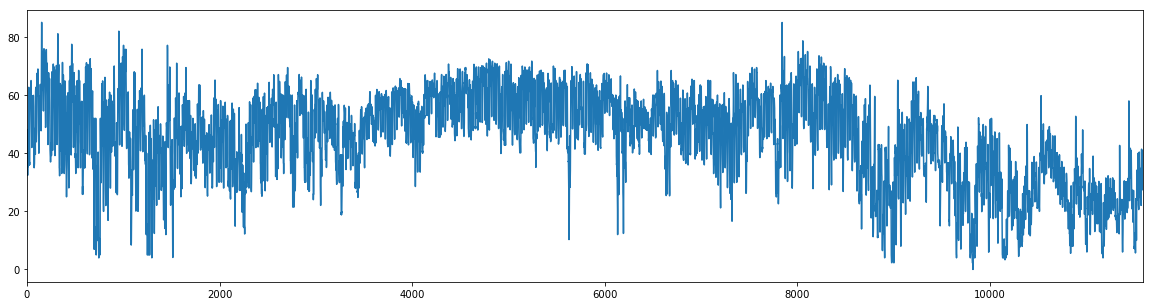

In [41]:
import tensorflow as tf
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import sklearn.metrics 
import math


energyPriceData= pd.read_csv("C:\\Users\\qc939dg\\Downloads\\priceData.csv",delimiter=',')
#print(columns)
columns = energyPriceData.columns.values
#print(columns)
energySeries = pd.Series(energyPriceData['Price'])
energySeries.plot(kind='line',figsize = (20,5))

TS1 = np.array(energyPriceData[1:5000])
energySeries.head(10)
TS = np.empty([len(TS1),1])

TS[:,0] = TS1[:,2]

num_periods = 20 #number of periods per vector we are using to predict one period ahead
f_horizon = 1  #forecast horizon, one period into the future


#print(len(TS))
N = len(TS)-(len(TS) % num_periods)
#print(N)
#print(TS)

x_data = TS[:N]
#print('x_data')
#print(x_data)


y_data = TS[1:N+f_horizon]

#print('ydata')
#print(y_data)
x_batches = x_data.reshape(-1, num_periods, 1)
y_batches = y_data.reshape(-1, num_periods, 1)

#print (len(x_batches))
#print (len(y_batches))
#print (x_batches.shape)
#print (y_batches.shape)


#print('x_batch')
#print (x_batches[0:2])
#print('y_batch')
#print (y_batches[0:2])

def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
#print (X_test.shape)
#print (X_test)

######################### tensorflow graph construction ###########################


tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

#num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 50          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
#loss = tf.reduce_sum(tf.square(outputs - y))
loss = tf.reduce_sum(abs(y-outputs)) #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 





init = tf.global_variables_initializer()           #initialize all the variables


epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    test_losses = []
    #test_accuracies = []
    train_losses = []
    #train_accuracies = []
    for ep in range(epochs):
        avg_cost = 0.
        avg_acc = 0.
       
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        #_,c,acc = sess.run([training_op,loss,accuracy], feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mae = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMAE:", mae)
            
            train_losses.append(mae)
            
            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            y_pred = sess.run(outputs, feed_dict={X: X_test})
            
           
            y_pred_array = pd.Series(np.ravel(y_pred))
            y_test_array = pd.Series(np.ravel(Y_test))
            test_mae =  sklearn.metrics.mean_absolute_error(y_pred_array, y_test_array)
           
            test_losses.append(test_mae)
            print("PERFORMANCE ON TEST SET: " + \
                  
                  "loss = {}".format(test_mae))


    #final prediction
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)
    
    y_pred_array = pd.Series(np.ravel(y_pred))
    y_test_array = pd.Series(np.ravel(Y_test))
    test_mae =  sklearn.metrics.mean_absolute_error(y_pred_array, y_test_array)
    
    test_losses.append(test_mae)
    

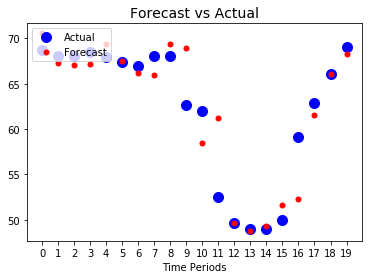

rmse = 3.121


In [42]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.xticks((range(20)))

plt.show()

rmse = math.sqrt(sklearn.metrics.mean_squared_error(pd.Series(np.ravel(Y_test)),pd.Series(np.ravel(y_pred))))
print('rmse = %.3f' % rmse)

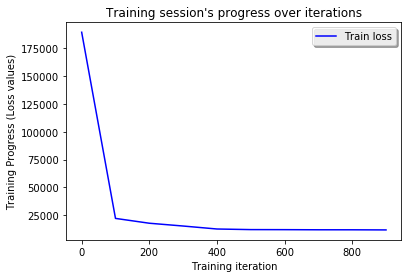

In [44]:
plt.plot(np.arange(0, 1000, 100),np.array(train_losses), "b", label="Train loss")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss values)')
plt.xlabel('Training iteration')

plt.show()

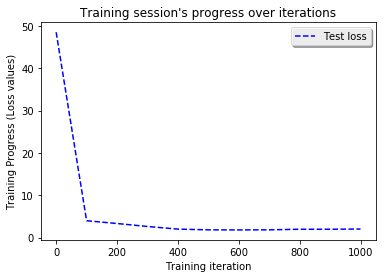

In [45]:
plt.plot(np.arange(0, 1100, 100),np.array(test_losses), "b--", label="Test loss")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss values)')
plt.xlabel('Training iteration')

plt.show()